In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm
from src.models import SpaceNet
from src.utils import ratemap_collage

plt.style.use("./figures/project_style.mplstyle")

In [2]:
msg = lambda beta, lam, scale: f"$\\beta$ = {beta}, $\\lambda$ = {lam}, $\\sigma$ = {scale}"

In [3]:
# evaluate on 32x32 grid
n = 32
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis = -1), dtype= torch.float32)

In [4]:
train_steps = 60000

n_in = 2 # 2 position inputs 
n_out = 256 # no. of spatial representations
bs = 64 # batch size 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

no_lam_model = SpaceNet(n_in, n_out, device = device, lam = 0)
optimizer = torch.optim.Adam(no_lam_model.parameters(), lr=1e-4)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype= torch.float32, device=device)
    loss = no_lam_model.train_step(x = r, y = r, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")


loss: 0.000019: 100%|██████████| 60000/60000 [00:53<00:00, 1118.68it/s]


In [5]:
no_beta_model = SpaceNet(n_in, n_out, device = device, beta = 0)
optimizer = torch.optim.Adam(no_beta_model.parameters(), lr=1e-4)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype= torch.float32, device=device)
    loss = no_beta_model.train_step(x = r, y = r, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")


loss: 0.001176: 100%|██████████| 60000/60000 [00:53<00:00, 1117.46it/s]


In [6]:
no_beta_no_lam_model = SpaceNet(n_in, n_out, device = device, beta = 0, lam = 0)
optimizer = torch.optim.Adam(no_beta_no_lam_model.parameters(), lr=1e-4)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype= torch.float32, device=device)
    loss = no_beta_no_lam_model.train_step(x = r, y = r, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000000: 100%|██████████| 60000/60000 [00:53<00:00, 1118.09it/s]


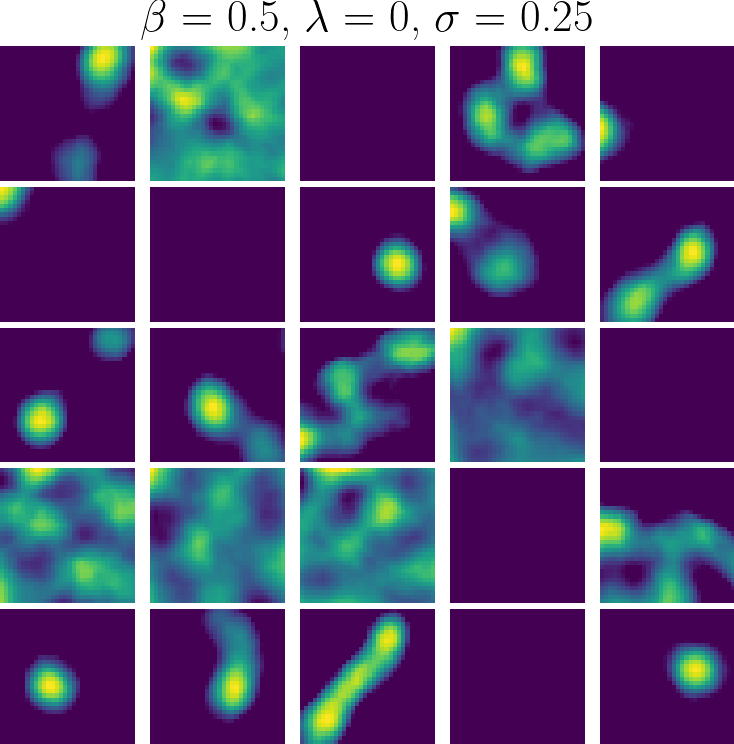

In [7]:
p_lam = (no_lam_model.spatial_representation(u).T).reshape(-1, n, n).detach().numpy()

ratemap_collage(p_lam[:25], cols = 5)

title = msg(0.5, 0, 0.25)
plt.suptitle(title)
plt.savefig(f"./figures/ablation_lambda")

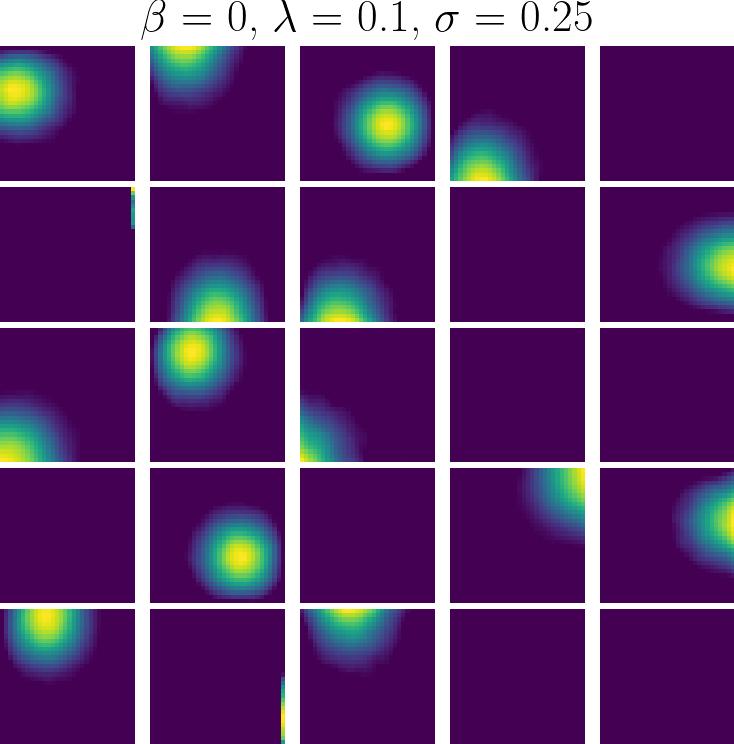

In [8]:
p_beta = no_beta_model.spatial_representation(u).detach().numpy().T.reshape(-1, n, n)
ratemap_collage(p_beta[:25], cols = 5);
title = msg(0,0.1,0.25)
plt.suptitle(title)
plt.savefig(f"./figures/ablation_beta")

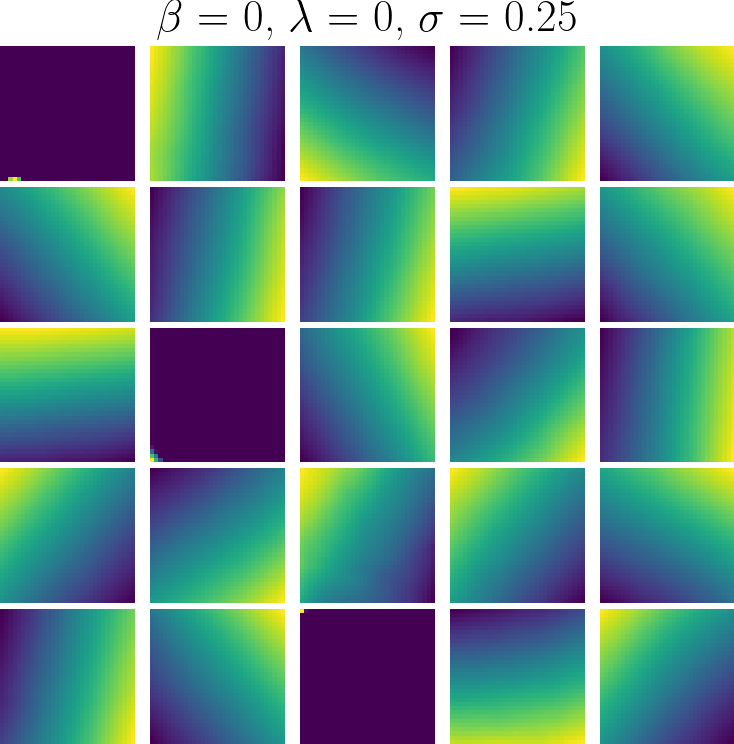

In [9]:
p_beta_lam = no_beta_no_lam_model.spatial_representation(u).detach().numpy().T.reshape(-1, n, n)
ratemap_collage(p_beta_lam[:25], cols = 5);
title = msg(0,0,0.25)
plt.suptitle(title)
plt.savefig(f"./figures/ablation_beta_lambda")

In [10]:
class AblateTuning(SpaceNet):
   def correlation_function(self, r):        
        dr = torch.nn.functional.pdist(r)
        correlation = torch.exp(-0.5 / self.scale ** 2 * dr)
        return correlation

In [11]:
# try different tuning (abs)
diff_tuning_model = AblateTuning(n_in, n_out, device = device, scale = 0.5)
optimizer = torch.optim.Adam(diff_tuning_model.parameters(), lr=1e-4)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype= torch.float32, device=device)
    loss = diff_tuning_model.train_step(x = r, y = r, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")


  0%|          | 0/60000 [00:00<?, ?it/s]

loss: 0.000200: 100%|██████████| 60000/60000 [00:49<00:00, 1224.06it/s]


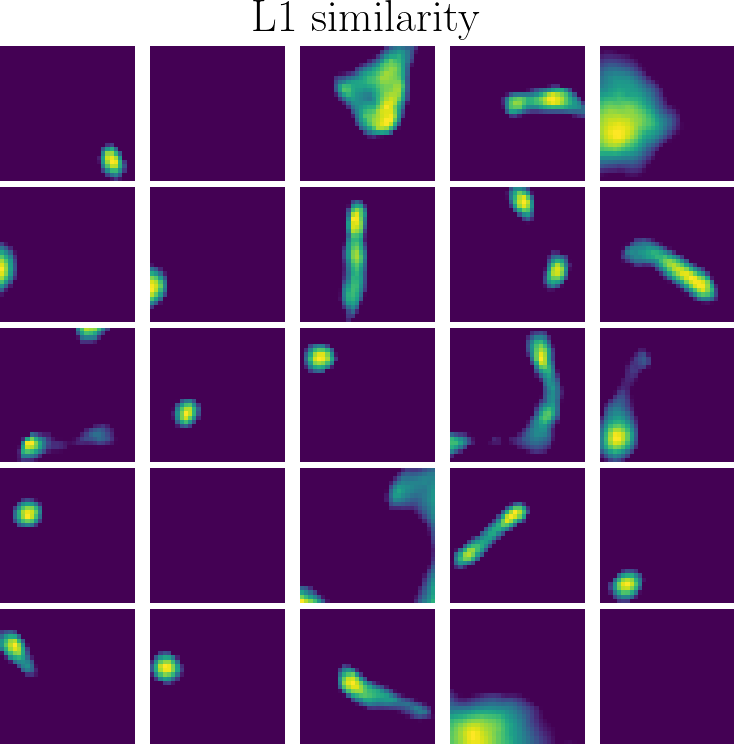

In [12]:
p_diff = diff_tuning_model.spatial_representation(u).detach().numpy().T.reshape(-1, n, n)
axs = ratemap_collage(p_diff[:25], cols = 5)
plt.suptitle("L1 similarity")
plt.savefig(f"./figures/ablation_L1_similarity")